In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM, load_random_exp_povm
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import clustering as cl
from EMQST_lib.qrem import QREM
from joblib import Parallel, delayed
import time
import uuid
import scipy.cluster.hierarchy as sch
from EMQST_lib import support_functions as sf
plt.rcParams.update({'font.size': 15})
np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2

# QREM on 16 qubits with structure, using (realistic exp. data)

In [2]:
# Generate new dictionary for current run
base_path = 'QDOT_results/16_exp_example'
data_path = sf.generate_data_folder(base_path)

sim_dict ={
    'n_qubits': 16,
    'n_QST_shots': 2*10**3,
    'n_QDT_shots': 10**4,
    'n_hash_symbols': 4,
    'n_cores': 9,
    'max_cluster_size': 3,
    'data_path': data_path,
}


# Ensure that cluster_sizes is a numpy array of integers
cluster_size = np.array([4, 1, 3, 2, 2, 1, 1, 2], dtype=int)

qrem = QREM(sim_dict)

qrem.print_current_state()

qrem.set_initial_cluster_size(cluster_size)
povm_mode = 'weak'
qrem.set_exp_POVM_array(noise_mode = povm_mode)
qrem.perform_QDT_measurements()
qrem.save_initialization()


Using hash from perfect_hash(9,16,4).npy.
The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 2,272 x 10,000.
QST shots for arbitrary 4-RDM reconstruction: 705 x 2,000.
Loaded 8 POVMs from Exp_povms/Extracted_modified.
Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   11.5s
[Parallel(n_jobs=9)]: Done 531 tasks      | elapsed:   12.8s
[Parallel(n_jobs=9)]: Done 1539 tasks      | elapsed:   15.1s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:   16.7s finished


Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   21.4s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   44.9s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    8.2s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   16.9s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   25.3s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   33.3s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   40.8s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   49.3s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:  1.0min
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.3min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.5min
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.8min remaining:    3.7s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.9min finished


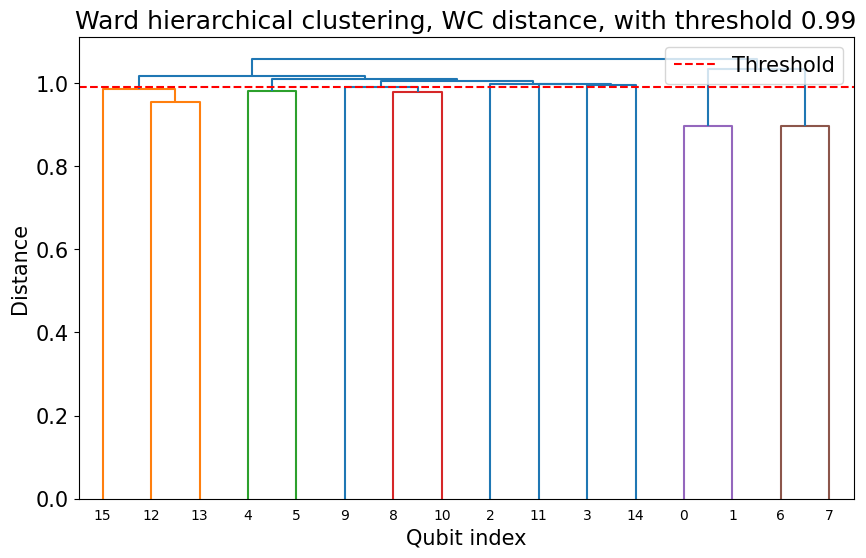

In [3]:
qrem.perform_clustering(max_cluster_size=4)
vis.plot_dendrogram(qrem)

# update_cutoffs = [ 0.9, 0.9, 0.8, 0.6]

# for qrem, cutoff in zip(qrem_array, update_cutoffs):
#     qrem.update_cluster_cutoff(cutoff)
#     vis.plot_dendrogram(qrem, save_png=True)


In [4]:
qrem.reconstruct_all_one_qubit_POVMs()
qrem.reconstruct_cluster_POVMs()
qrem.reconstruct_cluster_with_perfect_clustering()
n_averages = 3
chunk_size = 4
qrem.set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size)
qrem.perform_averaged_QST_measurements()

selected_two_point_corr_labels = np.array([[2,3], [4,8],[6,7],[14,15]])
random_two_pont_array = ot.generate_random_pairs_of_qubits(qrem.n_qubits, 10)
total_two_point_corr_labels = np.concatenate((selected_two_point_corr_labels, random_two_pont_array), axis=0)
qrem.set_two_point_correlators( two_point_corr_labels = total_two_point_corr_labels)
recon_mode = [0,1,2,3,4,5]

standard_dict = qrem.perform_two_point_correlator_QST(recon_mode)
#perfect_clustering_dict = qrem.perform_two_point_correlator_QST(recon_mode, assume_perfect_clustering=True)

dict_array = [standard_dict]#, perfect_clustering_dict]

with open(f'{qrem.data_path}/result_QST.npy', 'wb') as f:
    np.save(f, dict_array)

perm_data_path = f'{qrem.data_path}'



[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:   13.3s remaining:   57.9s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:   15.0s remaining:   33.1s
[Parallel(n_jobs=9)]: Done   7 out of  16 | elapsed:   15.2s remaining:   19.6s
[Parallel(n_jobs=9)]: Done   9 out of  16 | elapsed:   15.8s remaining:   12.2s
[Parallel(n_jobs=9)]: Done  11 out of  16 | elapsed:   16.4s remaining:    7.4s
[Parallel(n_jobs=9)]: Done  13 out of  16 | elapsed:   18.6s remaining:    4.2s
[Parallel(n_jobs=9)]: Done  16 out of  16 | elapsed:   19.2s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  10 | elapsed:    4.5s remaining:   10.7s
[Parallel(n_jobs=9)]: Done   5 out of  10 | elapsed:    4.8s remaining:    4.8s
[Parallel(n_jobs=9)]: Done   7 out of  10 | elapsed:    6.4s remaining:    2.7s
[Parallel(n_jobs=9)]: Done  10 out of  10 | elapsed:   13.6s

Set current two-point correlators to [[ 2  3]
 [ 4  8]
 [ 6  7]
 [14 15]
 [ 6 11]
 [13 14]
 [ 0  5]
 [ 3  7]
 [13  2]
 [ 3  6]
 [15 14]
 [ 4  1]
 [ 9  5]
 [ 7 13]].


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  14 | elapsed:    3.5s remaining:   13.2s
[Parallel(n_jobs=9)]: Done   6 out of  14 | elapsed:    3.6s remaining:    4.9s
[Parallel(n_jobs=9)]: Done   9 out of  14 | elapsed:    3.7s remaining:    2.0s
[Parallel(n_jobs=9)]: Done  12 out of  14 | elapsed:    5.8s remaining:    0.9s
[Parallel(n_jobs=9)]: Done  14 out of  14 | elapsed:    5.8s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  14 | elapsed:    7.2s remaining:   26.6s
[Parallel(n_jobs=9)]: Done   5 out of  14 | elapsed:    7.4s remaining:   13.4s
[Parallel(n_jobs=9)]: Done   7 out of  14 | elapsed:    8.0s remaining:    8.0s
[Parallel(n_jobs=9)]: Done   9 out of  14 | elapsed:    8.7s remaining:    4.8s
[Parallel(n_jobs=9)]: Done  11 out of  14 | elapsed:   12.5s remaining:    3.3s
[Parallel(n_jobs=9)]: Done  14 out of  14 | elapsed:   12.8s

POVM shape (4, 4, 4)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (32, 32, 32)
POVM shape (4, 4, 4)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (32, 32, 32)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  14 | elapsed:   11.7s remaining:   43.3s
[Parallel(n_jobs=9)]: Done   5 out of  14 | elapsed:   12.1s remaining:   21.9s
[Parallel(n_jobs=9)]: Done   7 out of  14 | elapsed:   12.3s remaining:   12.3s
[Parallel(n_jobs=9)]: Done   9 out of  14 | elapsed:   12.5s remaining:    6.9s
[Parallel(n_jobs=9)]: Done  11 out of  14 | elapsed:   13.6s remaining:    3.6s
[Parallel(n_jobs=9)]: Done  14 out of  14 | elapsed:   14.1s finished


POVM shape (4, 4, 4)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (32, 32, 32)
POVM shape (4, 4, 4)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (32, 32, 32)


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  14 | elapsed:   11.6s remaining:   42.7s
[Parallel(n_jobs=9)]: Done   5 out of  14 | elapsed:   11.8s remaining:   21.4s
[Parallel(n_jobs=9)]: Done   7 out of  14 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=9)]: Done   9 out of  14 | elapsed:   12.3s remaining:    6.8s
[Parallel(n_jobs=9)]: Done  11 out of  14 | elapsed:   13.3s remaining:    3.6s
[Parallel(n_jobs=9)]: Done  14 out of  14 | elapsed:   13.9s finished


POVM shape (4, 4, 4)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (32, 32, 32)
POVM shape (4, 4, 4)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (32, 32, 32)


[[ 2  3]
 [ 4  8]
 [ 6  7]
 [14 15]
 [ 6 11]
 [13 14]
 [ 0  5]
 [ 3  7]
 [13  2]
 [ 3  6]
 [15 14]
 [ 4  1]
 [ 9  5]
 [ 7 13]]
['No QREM ', 'Factorized QREM', 'Two-point QREM', 'Classical correlated QREM', 'Correlated QREM']
(5, 14)


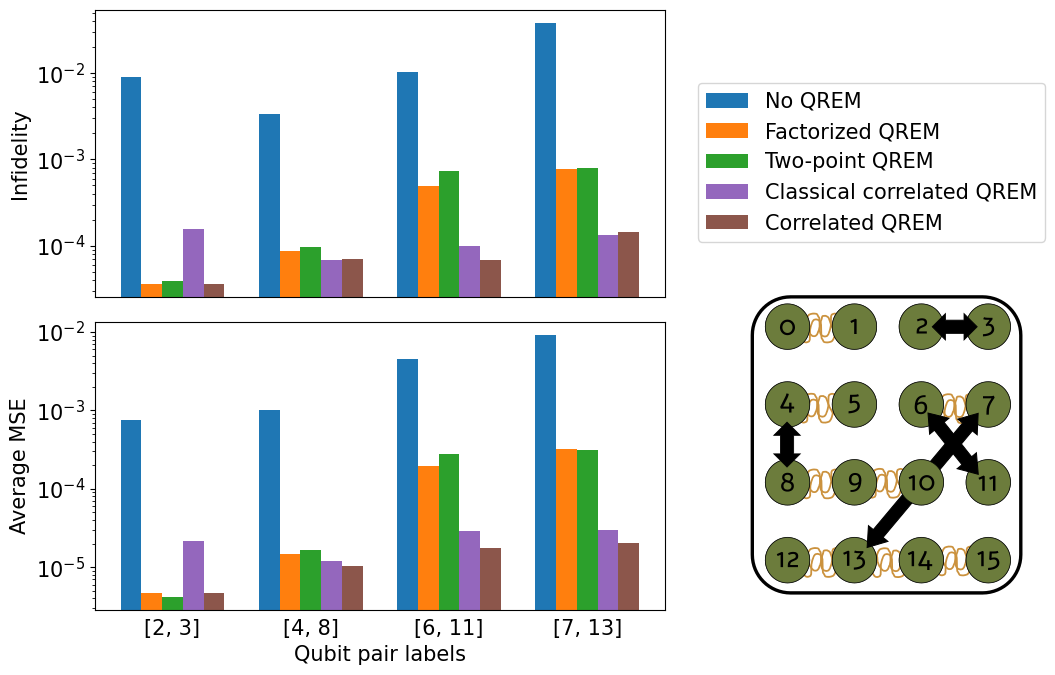

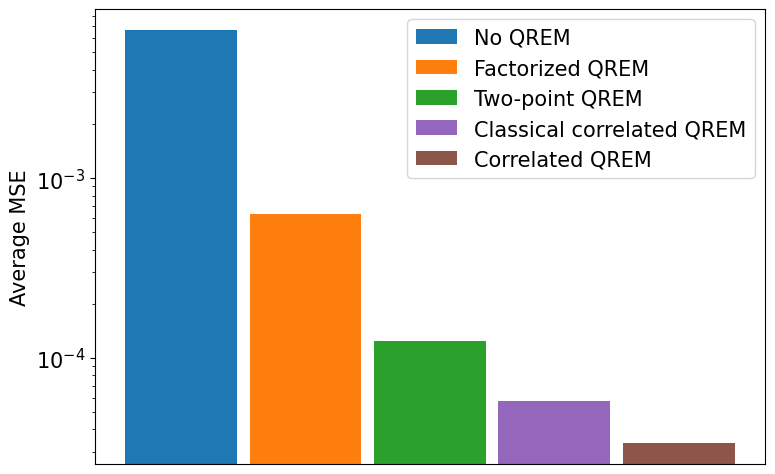

In [62]:
# Plotting
#data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"
filter_array = np.array([0,1,2,4,5])
perm_data_path = "QDOT_results/16_exp_example/2025-01-08_11-24-40_76b6b010-a87e-4347-8326-13f204534549"
with open(f'{perm_data_path}/result_QST.npy', 'rb') as f:
    dict_array = np.load(f, allow_pickle=True)

standard_dict = dict_array[0]
#perfect_clustering_dict = dict_array[1]
n_averages = standard_dict['n_average']
two_point_corr_labels   = standard_dict['two_point_corr_labels']
traced_down_rho_true_array = standard_dict['traced_down_rho_true_array']
print(two_point_corr_labels)
standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict)
#print(len(standard_state_array))
label_array.pop(3)
print(label_array)
#perfect_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict)
# The states has shapes [n_modes, n_averages, len(two_point_corr_labels), 2**n_qubits, 2**n_qubits]

fig, ax = plt.subplots(2,1)
if len(two_point_corr_labels) > 4:
    x = np.arange(4)  # How many correlators to plot
else:
    x = np.arange(len(two_point_corr_labels))
width = 0.15  # the width of the bars
multiplier = 0
corr_label_index = [0,1,4,-1]
standard_inf_array = ot.compute_mode_mean_infidelitites(standard_state_array, traced_down_rho_true_array)[filter_array]
#perfect_inf_array = ot.compute_mode_mean_infidelitites(standard_state_array, traced_down_rho_true_array)
print(standard_inf_array.shape)
color=['C0', 'C1','C2','C4','C5']
for i in range(len(label_array)):
    offset = width * multiplier
    if len(two_point_corr_labels) > 4:
        rects = ax[0].bar(x + offset,standard_inf_array[i,corr_label_index], width, label=label_array[i], color = color[i])
        #ax[0].plot(x + offset, perfect_inf_array[i,:,:4], "kx", label="Exact POVMs" if multiplier == 0 else "")
    else:
        rects = ax[0].bar(x + offset,standard_inf_array[i], width, label=label_array[i])
        #ax[0].plot(x + offset, perfect_inf_array[i], "kx", label="Exact POVMs" if multiplier == 0 else "")        
    multiplier += 1
ax[0].set_yscale('log')
if len(two_point_corr_labels) > 4:
    ax[0].set_xticks(x + 2.3*width, two_point_corr_labels[:4])
else:
    ax[0].set_xticks(x + 2.3*width, two_point_corr_labels)
ax[0].set_ylabel('Infidelity')


# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)




true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]
stadard_exp_value = ot.compute_state_array_exp_values(standard_state_array,op_string_array)

standard_mean_MSE = ot.compute_op_and_n_averages_mean_MSE(stadard_exp_value, true_exp_value)[filter_array]
#perfect_clustering_exp_value = ot.compute_state_array_exp_values(perfect_state_array,op_string_array)
#perfect_clustering_MSE = ot.compute_op_and_n_averages_mean_MSE(perfect_clustering_exp_value, true_exp_value)

# MSE of shape [n_method , n_correlators]

    
if len(two_point_corr_labels) > 4:
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels[corr_label_index]]
else:
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]

multiplier = 0

for i in range(len(label_array)):
    offset = width * multiplier
    if len(two_point_corr_labels) > 4:
        rects = ax[1].bar(x + offset, standard_mean_MSE[i,corr_label_index], width, color = color[i])
        #ax[1].plot(x + offset, perfect_clustering_MSE[i,:4], "kx")
    else:
        rects = ax[1].bar(x + offset, standard_mean_MSE[i], width)
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx")
    multiplier += 1
    
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')
ax[-1].set_xticks(x + 2*width, corr_x_label)
ax[-1].set_xlabel('Qubit pair labels')
img = plt.imread("images/Cluster_formation_16_qubit_example.png")
fig.figimage(img, 750, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(1,0.75))
fig.savefig(f'images/Results/Correlator_spesific_MSE_16_example.png')
handels, labels = ax[0].get_legend_handles_labels()





fig_main, ax_main = plt.subplots(1,1)
standard_mean_MSE = np.mean(standard_mean_MSE, axis=1)
#perfect_mean_MSE = np.mean(perfect_clustering_MSE, axis=1)
bars = ax_main.bar(label_array, standard_mean_MSE, width*6, color=['C0', 'C1','C2','C4','C5'])
#ax_main.plot(label_array, perfect_mean_MSE, "kx")
#ax_main.set_title('Average MSE over random correlators')
ax_main.set_ylabel('Average MSE')
ax_main.set_yscale('log')
ax_main.legend(handels, labels)
ax_main.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
fig_main.set_size_inches(8, 5)
fig_main.tight_layout()
fig_main.savefig(f'images/Results/main_result_16_example.png', dpi = 300)
#fig_main.legend(loc='center left', bbox_to_anchor=(1,0.75))



# QREM on 16 qubit for many differnet depolarizing ISAWP noise

## ISAWP noise

In [26]:
# Generate new dictionary for current run
base_path = 'QDOT_results/iswap_example'
k_mean_array = np.array([0.2, 0.4, 0.6, 0.8])

data_path = sf.generate_data_folder(base_path,subfolder_names=[f'k_mean={k_mean}' for k_mean in k_mean_array])


sim_dict ={
    'n_qubits': 16,
    'n_QST_shots': 10**3,
    'n_QDT_shots': 10**4,
    'n_hash_symbols': 4,
    'n_cores': 7,
    'max_cluster_size': 3,
    'data_path': data_path,
}


qrem_array = [QREM(sim_dict) for _ in range(len(k_mean_array))]

povm_mode = 'iSWAP'

for qrem, k_mean in zip(qrem_array, k_mean_array):
    #print(qrem._initial_cluster_size )
    qrem.set_correlated_POVM_array(k_mean = k_mean, noise_mode = povm_mode)
    save_path = f'{qrem.data_path}/k_mean={k_mean}'
    qrem.perform_QDT_measurements()
    qrem.save_initialization(save_path=save_path)


Using hash from perfect_hash(9,16,4).npy.
Using hash from perfect_hash(9,16,4).npy.
Using hash from perfect_hash(9,16,4).npy.
Using hash from perfect_hash(9,16,4).npy.
Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   10.1s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   10.4s
[Parallel(n_jobs=7)]: Done 554 tasks      | elapsed:   11.9s
[Parallel(n_jobs=7)]: Done 1562 tasks      | elapsed:   15.9s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:   18.3s finished


Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 226 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 946 tasks      | elapsed:    3.0s
[Parallel(n_jobs=7)]: Done 1954 tasks      | elapsed:    6.3s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    7.4s finished


Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 946 tasks      | elapsed:    3.1s
[Parallel(n_jobs=7)]: Done 1954 tasks      | elapsed:    6.6s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    7.6s finished


Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=7)]: Done 946 tasks      | elapsed:    3.8s
[Parallel(n_jobs=7)]: Done 1954 tasks      | elapsed:    7.1s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    8.1s finished


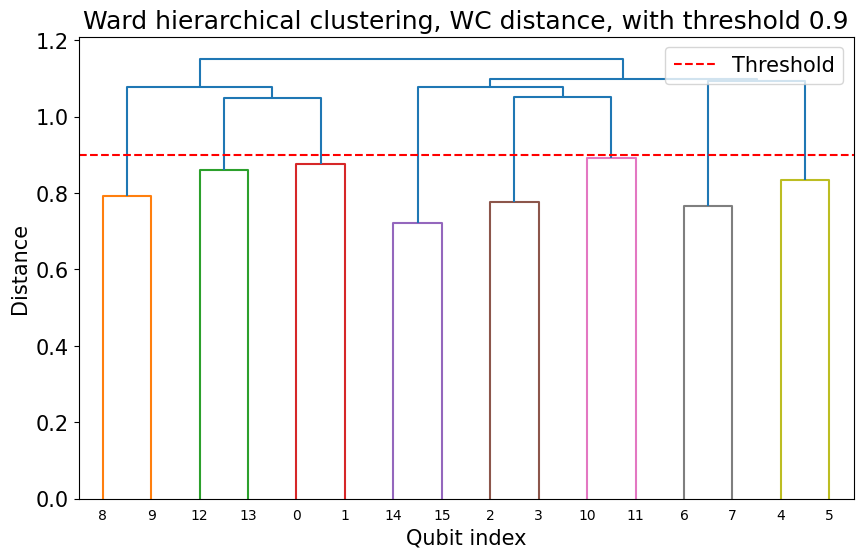

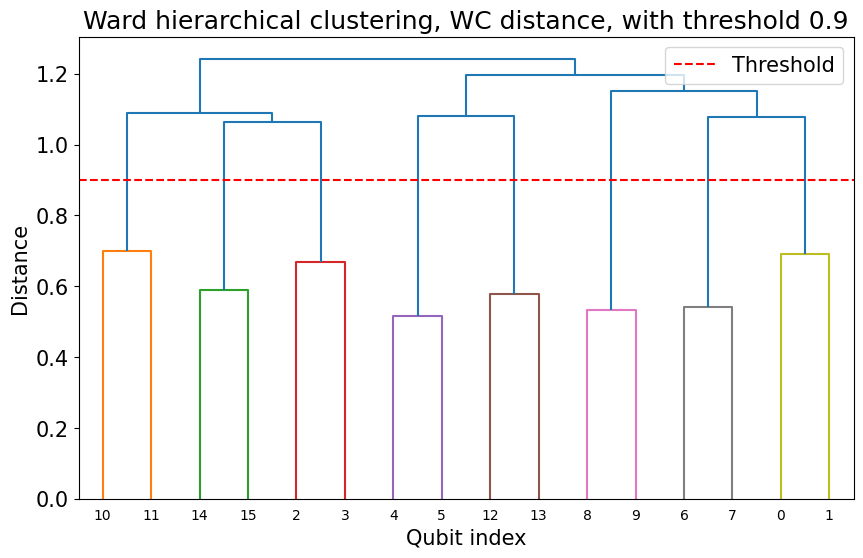

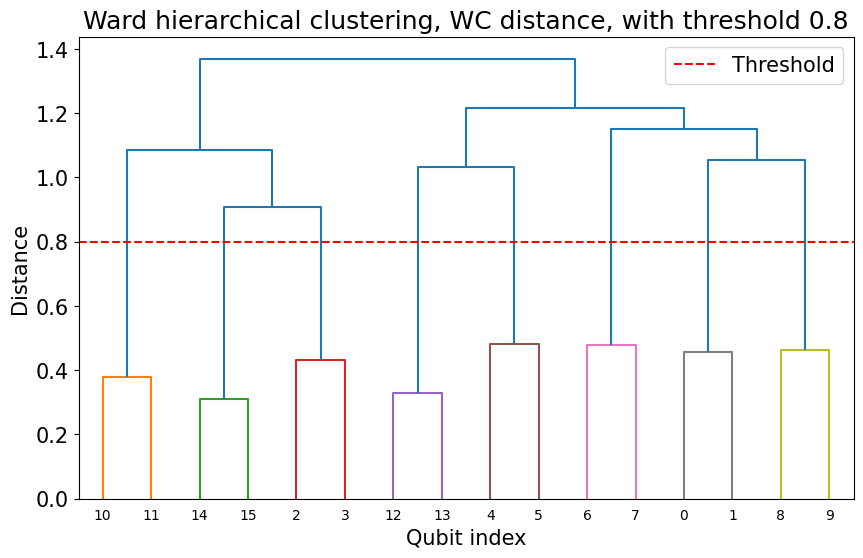

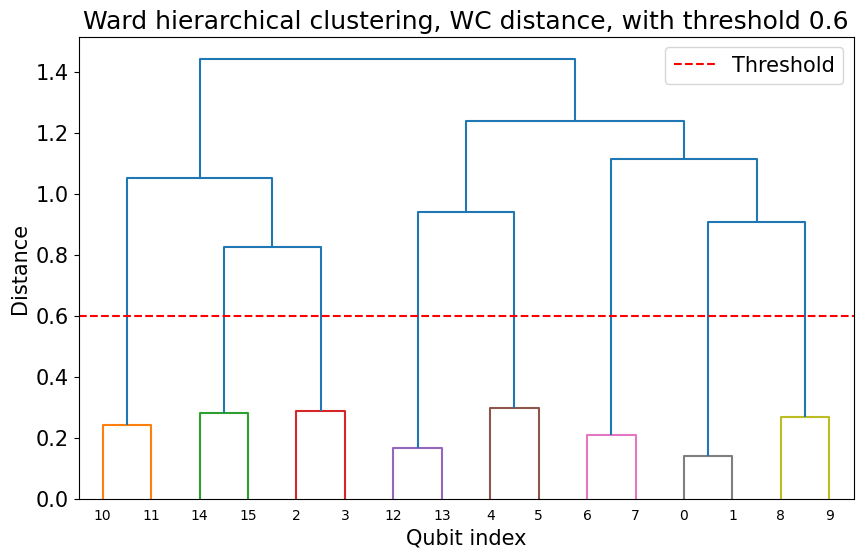

In [29]:
# for qrem in qrem_array:
#     qrem.perform_clustering(max_cluster_size=3)
#     vis.plot_dendrogram(qrem, save_png=True)

#If you are not happy with current cluster cutoffs, you can update them like so:
update_cutoffs = [ 0.9, 0.9, 0.8, 0.6]

for qrem, cutoff in zip(qrem_array, update_cutoffs):
    qrem.update_cluster_cutoff(cutoff)
    vis.plot_dendrogram(qrem, save_png=True)



In [30]:
n_pairs = 7
n_averages = 3
chunk_size = 4
selected_two_point_corr_labels = ot.generate_random_pairs_of_qubits(qrem.n_qubits,n_pairs) #np.array([[0,1], [2,3]])
recon_mode = [0,2,5]
standard_dict_array = []
perfect_clustering_dict_array = [] 

# Manually set true states equal in all k-mean cases.
qrem_array[0].set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size)
base_rho_true_array = qrem_array[0].rho_true_array


for qrem in qrem_array:
    qrem.reconstruct_all_one_qubit_POVMs()
    qrem.reconstruct_cluster_POVMs()
    qrem.reconstruct_cluster_with_perfect_clustering()
    qrem.set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size) # This is just used to set all other properties right, then overwrite the true states
    qrem.rho_true_array = base_rho_true_array

    qrem.perform_averaged_QST_measurements()
    qrem.set_two_point_correlators( two_point_corr_labels = selected_two_point_corr_labels)
    standard_dict = qrem.perform_two_point_correlator_QST(recon_mode)
    perfect_clustering_dict = qrem.perform_two_point_correlator_QST(recon_mode, assume_perfect_clustering=True)
    standard_dict_array.append(standard_dict)
    perfect_clustering_dict_array.append(perfect_clustering_dict)

dict_array = [standard_dict_array, perfect_clustering_dict_array]

with open(f'{qrem.data_path}/result_QST.npy', 'wb') as f:
    np.save(f, dict_array)

perm_data_path = f'{qrem.data_path}'

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:    9.6s remaining:   21.2s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:    9.7s remaining:   12.5s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   10.4s remaining:    8.1s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   11.6s remaining:    5.2s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   12.4s remaining:    2.8s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   12.7s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   8 | elapsed:    6.4s remaining:   19.5s
[Parallel(n_jobs=7)]: Done   3 out of   8 | elapsed:    6.5s remaining:   10.9s
[Parallel(n_jobs=7)]: Done   4 out of   8 | elapsed:    6.5s remaining:    6.5s
[Parallel(n_jobs=7)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.9s
[Parallel(n_jobs=7)]: Done   6 out of   8 | elapsed:    6.6s

Set current two-point correlators to [[ 4  6]
 [14  3]
 [13 14]
 [13 10]
 [ 3  9]
 [13  5]
 [ 6  2]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    3.1s remaining:    8.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    3.2s remaining:    2.4s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    3.2s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    1.2s remaining:    0.9s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    2.8s finished


POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:   10.5s remaining:   23.2s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:   10.7s remaining:   13.8s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   13.5s remaining:   10.4s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   13.5s remaining:    6.1s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   13.7s remaining:    3.1s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   15.0s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   8 | elapsed:    5.5s remaining:   16.7s
[Parallel(n_jobs=7)]: Done   3 out of   8 | elapsed:    5.5s remaining:    9.3s
[Parallel(n_jobs=7)]: Done   4 out of   8 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=7)]: Done   5 out of   8 | elapsed:    5.7s remaining:    3.4s
[Parallel(n_jobs=7)]: Done   6 out of   8 | elapsed:    5.7s

Set current two-point correlators to [[ 4  6]
 [14  3]
 [13 14]
 [13 10]
 [ 3  9]
 [13  5]
 [ 6  2]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    3.5s remaining:    9.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    3.6s remaining:    2.7s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    3.6s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    1.5s remaining:    2.1s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    2.1s remaining:    1.6s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    3.4s remaining:    1.3s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    4.2s finished


POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:   10.9s remaining:   24.1s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:   10.9s remaining:   14.1s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   14.2s remaining:   11.0s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   14.2s remaining:    6.4s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   14.3s remaining:    3.2s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   16.0s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   8 | elapsed:    5.9s remaining:   17.8s
[Parallel(n_jobs=7)]: Done   3 out of   8 | elapsed:    5.9s remaining:    9.9s
[Parallel(n_jobs=7)]: Done   4 out of   8 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=7)]: Done   5 out of   8 | elapsed:    5.9s remaining:    3.5s
[Parallel(n_jobs=7)]: Done   6 out of   8 | elapsed:    5.9s

Set current two-point correlators to [[ 4  6]
 [14  3]
 [13 14]
 [13 10]
 [ 3  9]
 [13  5]
 [ 6  2]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    3.5s remaining:    9.0s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    3.6s remaining:    2.7s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    3.6s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    2.2s remaining:    5.6s
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    2.6s remaining:    3.4s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    4.7s remaining:    3.5s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    4.9s remaining:    1.9s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    5.0s finished


POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:   10.5s remaining:   23.2s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:   10.7s remaining:   13.8s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   13.5s remaining:   10.4s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   13.6s remaining:    6.1s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   13.8s remaining:    3.1s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   15.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   8 | elapsed:    5.7s remaining:   17.2s
[Parallel(n_jobs=7)]: Done   3 out of   8 | elapsed:    5.7s remaining:    9.5s
[Parallel(n_jobs=7)]: Done   4 out of   8 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=7)]: Done   5 out of   8 | elapsed:    5.8s remaining:    3.4s
[Parallel(n_jobs=7)]: Done   6 out of   8 | elapsed:    5.8s

Set current two-point correlators to [[ 4  6]
 [14  3]
 [13 14]
 [13 10]
 [ 3  9]
 [13  5]
 [ 6  2]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    3.0s remaining:    7.7s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    3.1s remaining:    2.3s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    3.2s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    6.5s remaining:   16.5s
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:    6.6s remaining:    8.8s
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed:    6.6s remaining:    4.9s
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed:    6.6s remaining:    2.6s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    6.7s finished


POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.


### Plotting for the iSWAP noise case


(3, 4)
(3, 4)


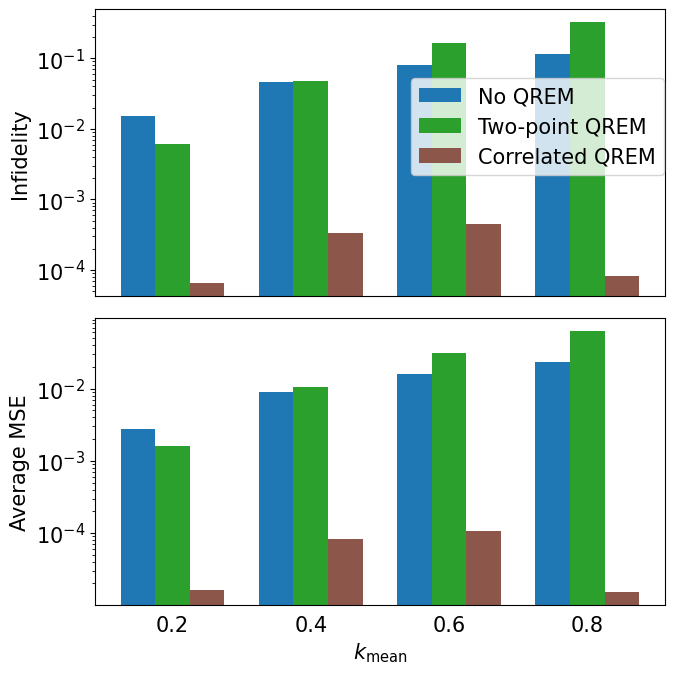

In [23]:
perm_data_path = "QDOT_results/iswap_example/2025-01-08_17-12-18_2c999945-7076-4ab9-b755-c99d76a85d1f/k_mean=0.8"
with open(f'{perm_data_path}/result_QST.npy', 'rb') as f:
    dict_array = np.load(f, allow_pickle=True)
standard_dict_array  = dict_array[0]
perfect_clustering_dict_array = dict_array[1]
k_mean_array = [0.2, 0.4, 0.6, 0.8]
# We need to treat each k-mean on it's own.
standard_state_matrix = []
perfect_clustering_state_matrix = []

for k_it in range(len(standard_dict_array)):
    standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict_array[k_it])
    perfect_clustering_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict_array[k_it])
    standard_state_matrix.append(standard_state_array)
    perfect_clustering_state_matrix.append(perfect_clustering_state_array)

traced_down_rho_true_array = standard_dict_array[k_it]['traced_down_rho_true_array']
n_averages = standard_dict_array[k_it]['n_average']
two_point_corr_labels   = standard_dict_array[k_it]['two_point_corr_labels']



# # Compute infidelities:
# The matrix has the shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
# traced_down_rho_true_array has the shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]

def k_mean_infidelity_computation(state_matrix, rho_true_array):
    """
    Computes the inifdelities to be plotted for the k-mean plot
    state_matrix comes in shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
    rho_true_array comes in shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]

    will return infidelities averaged over n_averages and n_two_point_corr, final shape will be [n_k_mean, n_modes]
    """
    mode_mean_inf = [ot.compute_mode_mean_infidelitites(k_mean,rho_true_array) for k_mean in state_matrix]
    # Returns a list of arrays of shape [n_k_mean, n_modes, len(two_point_corr_labels)]
    return np.mean(mode_mean_inf, axis = 2)

inf_average_standard = k_mean_infidelity_computation(standard_state_matrix, traced_down_rho_true_array).T # T is to swap order of modes and k_mean
inf_average_perfect_clustering = k_mean_infidelity_computation(perfect_clustering_state_matrix, traced_down_rho_true_array).T
# Has the shape [n_recon_modes, n_k_mean]
print(inf_average_standard.shape)
x = np.arange(len(k_mean_array))  # the k-mean label locations
color_array = ['C0', 'C2', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

for i in range(len(label_array)): 
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_average_standard[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    #ax[0].plot(x + offset, inf_average_perfect_clustering[i], "kx", label="Perfect clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, k_mean_array)
ax[0].set_ylabel('Infidelity')





# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)

def compute_k_mean_expectation_values(state_matrix,op_string_array):
    """
    Computes expectation values for a given state matrix.
    state_matrix shape has [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
    returns expectation values of shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels), n_op]
    """
    return np.array([ot.compute_state_array_exp_values(matrix,op_string_array) for matrix in state_matrix])

def compute_k_mean_mean_MSE(exp_value_array, true_exp_value):
    """
    Computes the mean MSE for a given expectation value array
    true_exp_value is of shape [n_averages, len(two_point_corr_labels), n_op]
    exp_value_array is of shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels), n_op]
    returns an array of shape [n_k_mean, n_modes]
    """
    return np.array([[np.mean((true_exp_value - mode)**2) for mode in k_mean] for k_mean in exp_value_array])

true_exp_value = compute_k_mean_expectation_values([[traced_down_rho_true_array]],op_string_array)[0,0]
stadard_exp_value = compute_k_mean_expectation_values(standard_state_matrix,op_string_array)
perfect_clustering_exp_value_array = compute_k_mean_expectation_values(perfect_clustering_state_matrix,op_string_array)
standard_mean_MSE = compute_k_mean_mean_MSE(stadard_exp_value, true_exp_value ).T # Transpose to make method be outer layer
perfect_clustering_MSE = compute_k_mean_mean_MSE(perfect_clustering_exp_value_array, true_exp_value ).T

print(standard_mean_MSE.shape)
multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, standard_mean_MSE[i], width, color = color_array[i])
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')


ax[-1].set_xticks(x + 1*width, k_mean_array)

ax[-1].set_xticks(x + 1*width, k_mean_array)
ax[-1].set_xlabel(r'$k_{\text{mean}}$')

#img = plt.imread("images/cluster_formation_16_iSWAP.png")
#fig.figimage(img, 680, 80, zorder=3, alpha=1)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom = True) # labels along the bottom edge are off


fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.59,0.8))
fig.savefig(f'images/Results/iSWAP_example.png', dpi = 300)

## Coherent error example

In [43]:
# Generate new dictionary for current run
base_path = 'QDOT_results/coherent_example'
rot_angle_array = np.array([5,10,20,30])* np.pi/100
data_path = sf.generate_data_folder(base_path,subfolder_names=[f'angle={angle}' for angle in rot_angle_array])


sim_dict ={
    'n_qubits': 16,
    'n_QST_shots': 10**3,
    'n_QDT_shots': 10**4,
    'n_hash_symbols': 4,
    'n_cores': 7,
    'max_cluster_size': 3,
    'data_path': data_path,
}
# Constant overrotation_angle

qrem_array = [QREM(sim_dict) for _ in range(len(rot_angle_array))]

# Ensure that cluster_sizes is a numpy array of integers
cluster_size = np.array([1, 3, 1, 3, 2, 2, 1, 2, 1], dtype=int)

for qrem, angle in zip(qrem_array, rot_angle_array):
    qrem.set_initial_cluster_size(cluster_size)
    qrem.set_coherent_POVM_array(angle = angle)
    save_path = f'{qrem.data_path}/angle={angle}'
    qrem.perform_QDT_measurements()
    qrem.save_initialization(save_path=save_path)

Using hash from perfect_hash(9,16,4).npy.
Using hash from perfect_hash(9,16,4).npy.
Using hash from perfect_hash(9,16,4).npy.
Using hash from perfect_hash(9,16,4).npy.
Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 1682 tasks      | elapsed:    3.0s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    4.8s finished


Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 946 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done 1954 tasks      | elapsed:    7.0s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    8.4s finished


Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 226 tasks      | elapsed:    1.1s
[Parallel(n_jobs=7)]: Done 946 tasks      | elapsed:    3.9s
[Parallel(n_jobs=7)]: Done 1954 tasks      | elapsed:    7.7s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    8.7s finished


Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 226 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 946 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done 1954 tasks      | elapsed:    5.7s
[Parallel(n_jobs=7)]: Done 2272 out of 2272 | elapsed:    6.7s finished


Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   25.4s
[Parallel(n_jobs=7)]: Done 120 out of 120 | elapsed:   49.0s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    5.5s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   11.0s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   16.8s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   23.1s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   29.6s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   40.4s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   47.7s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   57.6s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 120 out of 120 | elap

Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   27.4s
[Parallel(n_jobs=7)]: Done 120 out of 120 | elapsed:   50.4s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    6.8s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   11.3s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   19.5s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   33.7s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   39.5s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   48.1s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   54.9s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 120 out of 120 | elap

Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   23.6s
[Parallel(n_jobs=7)]: Done 120 out of 120 | elapsed:   46.7s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    9.2s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   18.1s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   25.3s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   36.2s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   43.7s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   55.4s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 120 out of 120 | elap

Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   25.3s
[Parallel(n_jobs=7)]: Done 120 out of 120 | elapsed:   48.6s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    5.5s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    8.4s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   13.1s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   19.7s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   25.3s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   32.5s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   39.6s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   47.9s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   57.5s
[Parallel(n_jobs=7)]: Done  99 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 120 out of 120 | elap

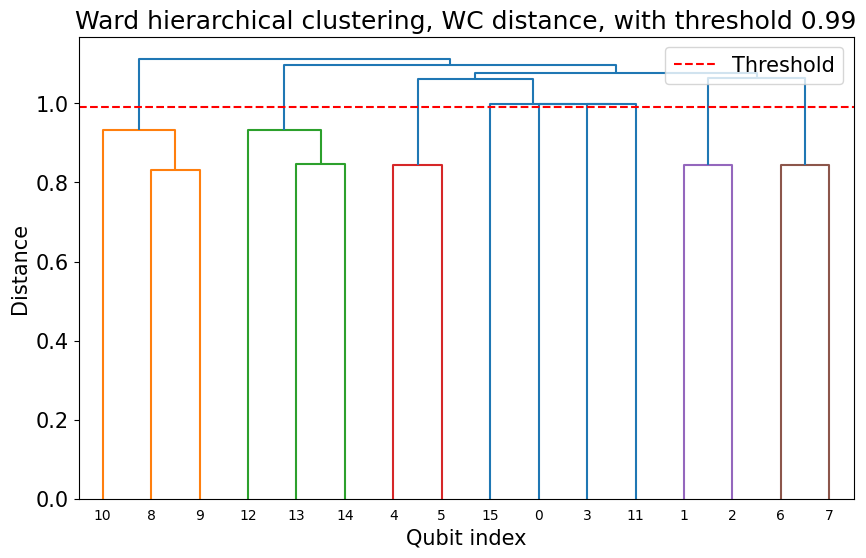

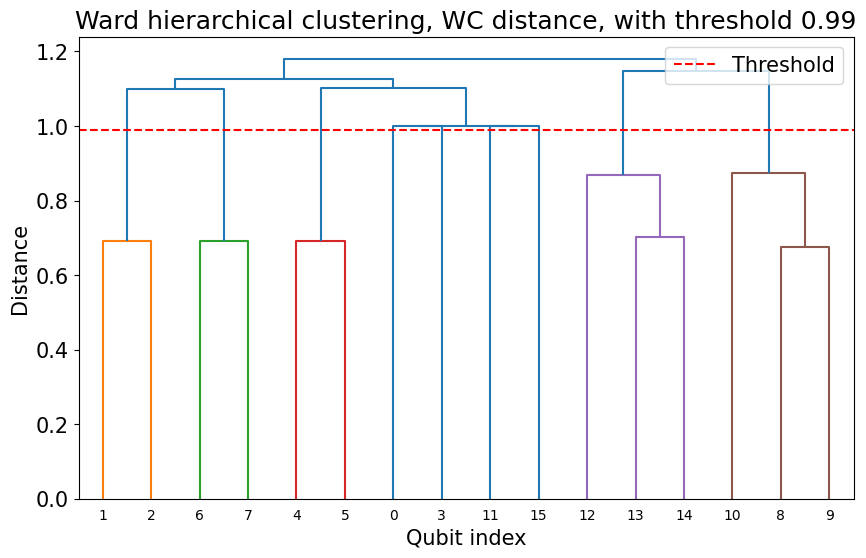

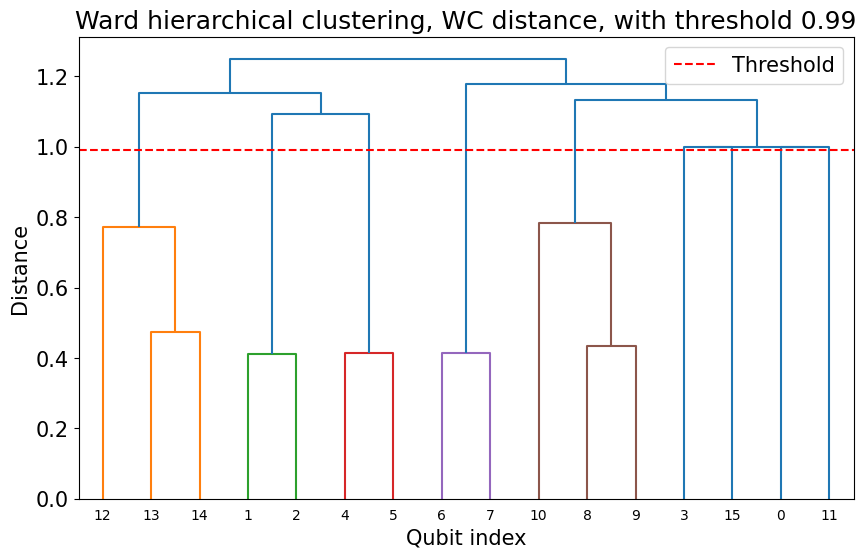

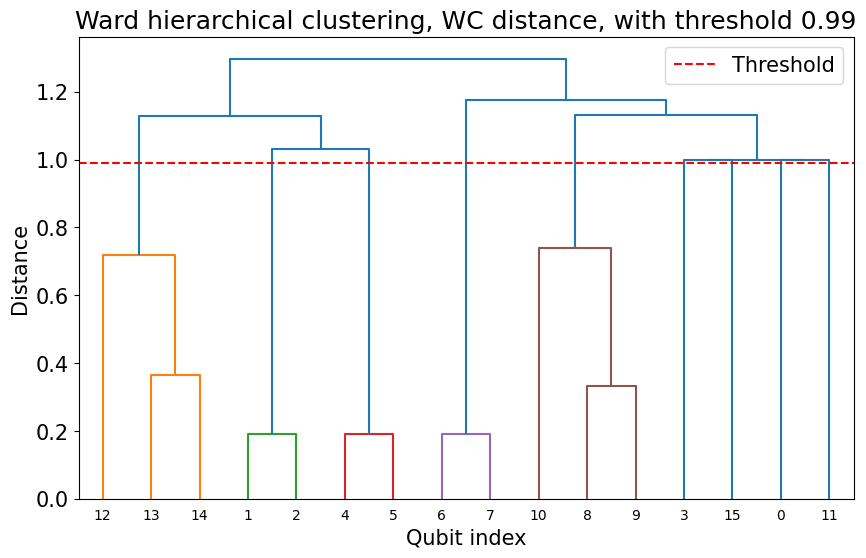

In [44]:
for qrem in qrem_array:
    qrem.perform_clustering(max_cluster_size=3)
    vis.plot_dendrogram(qrem, save_png=True)

# If you are not happy with current cluster cutoffs, you can update them like so:
# update_cutoffs = [ 0.98, 0.97]

# for qrem, cutoff in zip(qrem_array, update_cutoffs):
#     qrem.update_cluster_cutoff(cutoff)
#     vis.plot_dendrogram(qrem, save_png=True)


In [46]:
n_pairs = 10
n_averages = 2
chunk_size = 4
selected_two_point_corr_labels = ot.generate_random_pairs_of_qubits(qrem.n_qubits,n_pairs) # np.array([[0,1], [2,3]]) #
recon_mode = [0,4,5]
standard_dict_array = []
perfect_clustering_dict_array = [] 

# Manually set true states equal in all angle cases.
qrem_array[0].set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size)
base_rho_true_array = qrem_array[0].rho_true_array


for qrem in qrem_array:
    qrem.reconstruct_all_one_qubit_POVMs()
    qrem.reconstruct_cluster_POVMs()
    qrem.reconstruct_cluster_with_perfect_clustering()
    qrem.set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size) # This is just used to set all other properties right, then overwrite the true states
    qrem.rho_true_array = base_rho_true_array

    qrem.perform_averaged_QST_measurements()
    qrem.set_two_point_correlators( two_point_corr_labels = selected_two_point_corr_labels)
    standard_dict = qrem.perform_two_point_correlator_QST(recon_mode)
    perfect_clustering_dict = qrem.perform_two_point_correlator_QST(recon_mode, assume_perfect_clustering=True)
    standard_dict_array.append(standard_dict)
    perfect_clustering_dict_array.append(perfect_clustering_dict)

dict_array = [standard_dict_array, perfect_clustering_dict_array]

with open(f'{qrem.data_path}/result_QST.npy', 'wb') as f:
    np.save(f, dict_array)

perm_data_path = f'{qrem.data_path}'

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:    9.0s remaining:   19.9s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:    9.7s remaining:   12.5s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   10.2s remaining:    7.9s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   10.3s remaining:    4.6s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   10.4s remaining:    2.3s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   12.2s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   9 | elapsed:    3.8s remaining:   13.6s
[Parallel(n_jobs=7)]: Done   3 out of   9 | elapsed:    3.8s remaining:    7.8s
[Parallel(n_jobs=7)]: Done   4 out of   9 | elapsed:    3.9s remaining:    4.9s
[Parallel(n_jobs=7)]: Done   5 out of   9 | elapsed:    6.0s remaining:    4.8s
[Parallel(n_jobs=7)]: Done   6 out of   9 | elapsed:    8.9s

Set current two-point correlators to [[11  2]
 [ 3  8]
 [ 5 15]
 [ 9  1]
 [11 14]
 [12  7]
 [ 7  6]
 [ 9  5]
 [11 14]
 [15  3]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    3.4s remaining:    8.0s
[Parallel(n_jobs=7)]: Done   6 out of  10 | elapsed:    3.4s remaining:    2.2s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    7.0s remaining:   16.4s
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:    7.0s remaining:    7.0s
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:    7.1s remaining:    3.0s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:   10.4s finished


POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:   10.9s remaining:   24.2s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:   11.0s remaining:   14.1s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   11.9s remaining:    9.2s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   12.1s remaining:    5.4s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   13.8s remaining:    3.1s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   14.4s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   9 | elapsed:    3.1s remaining:   11.1s
[Parallel(n_jobs=7)]: Done   3 out of   9 | elapsed:    3.1s remaining:    6.3s
[Parallel(n_jobs=7)]: Done   4 out of   9 | elapsed:    3.1s remaining:    3.9s
[Parallel(n_jobs=7)]: Done   5 out of   9 | elapsed:    4.9s remaining:    3.9s
[Parallel(n_jobs=7)]: Done   6 out of   9 | elapsed:    4.9s

Set current two-point correlators to [[11  2]
 [ 3  8]
 [ 5 15]
 [ 9  1]
 [11 14]
 [12  7]
 [ 7  6]
 [ 9  5]
 [11 14]
 [15  3]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    3.7s remaining:    8.8s
[Parallel(n_jobs=7)]: Done   6 out of  10 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    6.1s remaining:   14.4s
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:    6.3s remaining:    2.6s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    9.9s finished


POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:    9.2s remaining:   20.3s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:    9.3s remaining:   12.0s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   11.8s remaining:    9.1s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   11.9s remaining:    5.4s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   12.2s remaining:    2.7s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   13.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   9 | elapsed:    3.0s remaining:   10.8s
[Parallel(n_jobs=7)]: Done   3 out of   9 | elapsed:    4.9s remaining:   10.0s
[Parallel(n_jobs=7)]: Done   4 out of   9 | elapsed:    5.0s remaining:    6.2s
[Parallel(n_jobs=7)]: Done   5 out of   9 | elapsed:    5.1s remaining:    4.1s
[Parallel(n_jobs=7)]: Done   6 out of   9 | elapsed:    6.0s

Set current two-point correlators to [[11  2]
 [ 3  8]
 [ 5 15]
 [ 9  1]
 [11 14]
 [12  7]
 [ 7  6]
 [ 9  5]
 [11 14]
 [15  3]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    2.9s remaining:    6.8s
[Parallel(n_jobs=7)]: Done   6 out of  10 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    5.3s remaining:   12.6s
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:    5.5s remaining:    2.3s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    9.3s finished


POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   5 out of  16 | elapsed:    9.9s remaining:   22.0s
[Parallel(n_jobs=7)]: Done   7 out of  16 | elapsed:   10.1s remaining:   13.0s
[Parallel(n_jobs=7)]: Done   9 out of  16 | elapsed:   12.7s remaining:    9.8s
[Parallel(n_jobs=7)]: Done  11 out of  16 | elapsed:   12.7s remaining:    5.7s
[Parallel(n_jobs=7)]: Done  13 out of  16 | elapsed:   12.9s remaining:    2.9s
[Parallel(n_jobs=7)]: Done  16 out of  16 | elapsed:   14.5s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   9 | elapsed:    3.1s remaining:   11.0s
[Parallel(n_jobs=7)]: Done   3 out of   9 | elapsed:    5.1s remaining:   10.3s
[Parallel(n_jobs=7)]: Done   4 out of   9 | elapsed:    5.1s remaining:    6.4s
[Parallel(n_jobs=7)]: Done   5 out of   9 | elapsed:    5.2s remaining:    4.2s
[Parallel(n_jobs=7)]: Done   6 out of   9 | elapsed:    6.2s

Set current two-point correlators to [[11  2]
 [ 3  8]
 [ 5 15]
 [ 9  1]
 [11 14]
 [12  7]
 [ 7  6]
 [ 9  5]
 [11 14]
 [15  3]].


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.5s
[Parallel(n_jobs=7)]: Done   6 out of  10 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=7)]: Done   5 out of  10 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=7)]: Done   7 out of  10 | elapsed:    5.5s remaining:    2.3s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    8.6s finished


POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already 

### Plotting for the coherent error case

(3, 4)
(3, 4)


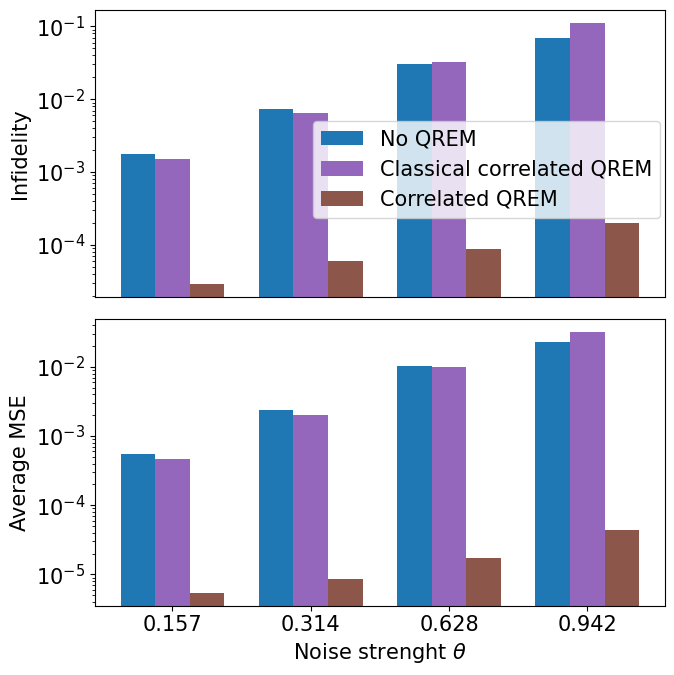

In [39]:
perm_data_path = "QDOT_results/coherent_example/2025-01-09_11-24-07_634d8d29-0158-4353-a0f5-cae6c9e83af7/angle=0.9424777960769378"
rot_angle_array = np.array([5,10,20,30])* np.pi/100
np.set_printoptions(precision=3)
with open(f'{perm_data_path}/result_QST.npy', 'rb') as f:
    dict_array = np.load(f, allow_pickle=True)
standard_dict_array  = dict_array[0]
perfect_clustering_dict_array = dict_array[1]

# We need to treat each k-mean on it's own.
standard_state_matrix = []
perfect_clustering_state_matrix = []

for k_it in range(len(standard_dict_array)):
    standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict_array[k_it])
    perfect_clustering_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict_array[k_it])
    standard_state_matrix.append(standard_state_array)
    perfect_clustering_state_matrix.append(perfect_clustering_state_array)

traced_down_rho_true_array = standard_dict_array[k_it]['traced_down_rho_true_array']
n_averages = standard_dict_array[k_it]['n_average']
two_point_corr_labels   = standard_dict_array[k_it]['two_point_corr_labels']

# # Compute infidelities:
# The matrix has the shape [n_k_mean, n_modes, n_averages, len(two_point_corr_labels) , 2**n_qubits, 2**n_qubits]
# traced_down_rho_true_array has the shape [n_averages, n_two_point_corr, 2**n_qubits, 2**n_qubits]

inf_average_standard = ot.k_mean_infidelity_computation(standard_state_matrix, traced_down_rho_true_array).T # T is to swap order of modes and k_mean
inf_average_perfect_clustering = ot.k_mean_infidelity_computation(perfect_clustering_state_matrix, traced_down_rho_true_array).T
# Has the shape [n_recon_modes, n_k_mean]
print(inf_average_standard.shape)
x = np.arange(len(rot_angle_array))  # the k-mean label locations
color_array = ['C0', 'C4', 'C5']
width = 0.25  # the width of the bars
multiplier = 0
# The shape of the array is 
fig, ax = plt.subplots(2,1)

for i in range(len(label_array)): 
    offset = width * multiplier
    rects = ax[0].bar(x + offset, inf_average_standard[i], width,label=label_array[i], color = color_array[i]) # Transpose to make method be outer layer
    #ax[0].plot(x + offset, inf_average_perfect_clustering[i], "kx", label="Perfect clustering" if multiplier == 0 else "")
    multiplier += 1

ax[0].set_yscale('log')
#ax[0,0].set_title(rf"Average over {n_averages} states.")
ax[0].set_xticks(x + width, rot_angle_array)
ax[0].set_ylabel('Infidelity')



# Generate average Pauli expectation values
n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)



true_exp_value = ot.compute_k_mean_expectation_values([[traced_down_rho_true_array]],op_string_array)[0,0]
stadard_exp_value = ot.compute_k_mean_expectation_values(standard_state_matrix,op_string_array)
perfect_clustering_exp_value_array = ot.compute_k_mean_expectation_values(perfect_clustering_state_matrix,op_string_array)
standard_mean_MSE = ot.compute_k_mean_mean_MSE(stadard_exp_value, true_exp_value ).T # Transpose to make method be outer layer
perfect_clustering_MSE = ot.compute_k_mean_mean_MSE(perfect_clustering_exp_value_array, true_exp_value ).T

print(standard_mean_MSE.shape)
multiplier = 0
for i in range(len(label_array)):
    offset = width * multiplier
    rects = ax[1].bar(x + offset, standard_mean_MSE[i], width, color = color_array[i])
    #ax[1].plot(x + offset, perfect_clustering_MSE[i], "kx",)
    multiplier += 1
    

ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].set_yscale('log')
ax[1].set_ylabel(f'Average MSE')

ax[-1].set_xticks(x + 1*width, np.round(rot_angle_array, 3))
ax[-1].set_xlabel(r'Noise strenght $\theta$')

#img = plt.imread("images/cluster_formation_16_coherent.png")
#fig.figimage(img, 680, 80, zorder=3, alpha=1)

fig.set_size_inches(7, 7)
fig.tight_layout()
fig.legend(loc='center left', bbox_to_anchor=(0.45,0.74))
fig.savefig(f'images/Results/coherence_example.png', dpi = 300)


# 100 qubit example, random correlators
The 100 qubit example will simply be a mean over random correlators. 

In [2]:
# Generate new dictionary for current run
base_path = 'QDOT_results/100_qubit_example'
data_path = sf.generate_data_folder(base_path)

sim_dict ={
    'n_qubits': 100,
    'n_QST_shots': 10**3,
    'n_QDT_shots': 10**3,
    'n_hash_symbols': 4,
    'n_cores': 9,
    'max_cluster_size': 3,
    'data_path': data_path,
}

# Ensure that cluster_sizes is a numpy array of integers
#cluster_size = np.array([1, 3, 1, 3, 2, 2, 1, 2, 1], dtype=int)

qrem = QREM(sim_dict)

qrem.print_current_state()

qrem.set_random_cluster_size()
povm_mode = 'weak'
qrem.set_exp_POVM_array( noise_mode = povm_mode)
qrem.perform_QDT_measurements()
qrem.save_initialization()



Using hash from perfect_hash(16,100,4).npy.
The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 4,036 x 1,000.
QST shots for arbitrary 4-RDM reconstruction: 1,251 x 1,000.
Loaded 59 POVMs from Exp_povms/Extracted_modified.
Simulating QDT measurements for 100 qubits.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   15.0s
[Parallel(n_jobs=9)]: Done 216 tasks      | elapsed:   15.9s
[Parallel(n_jobs=9)]: Done 1224 tasks      | elapsed:   18.7s
[Parallel(n_jobs=9)]: Done 2520 tasks      | elapsed:   22.8s
[Parallel(n_jobs=9)]: Done 4036 out of 4036 | elapsed:   27.2s finished


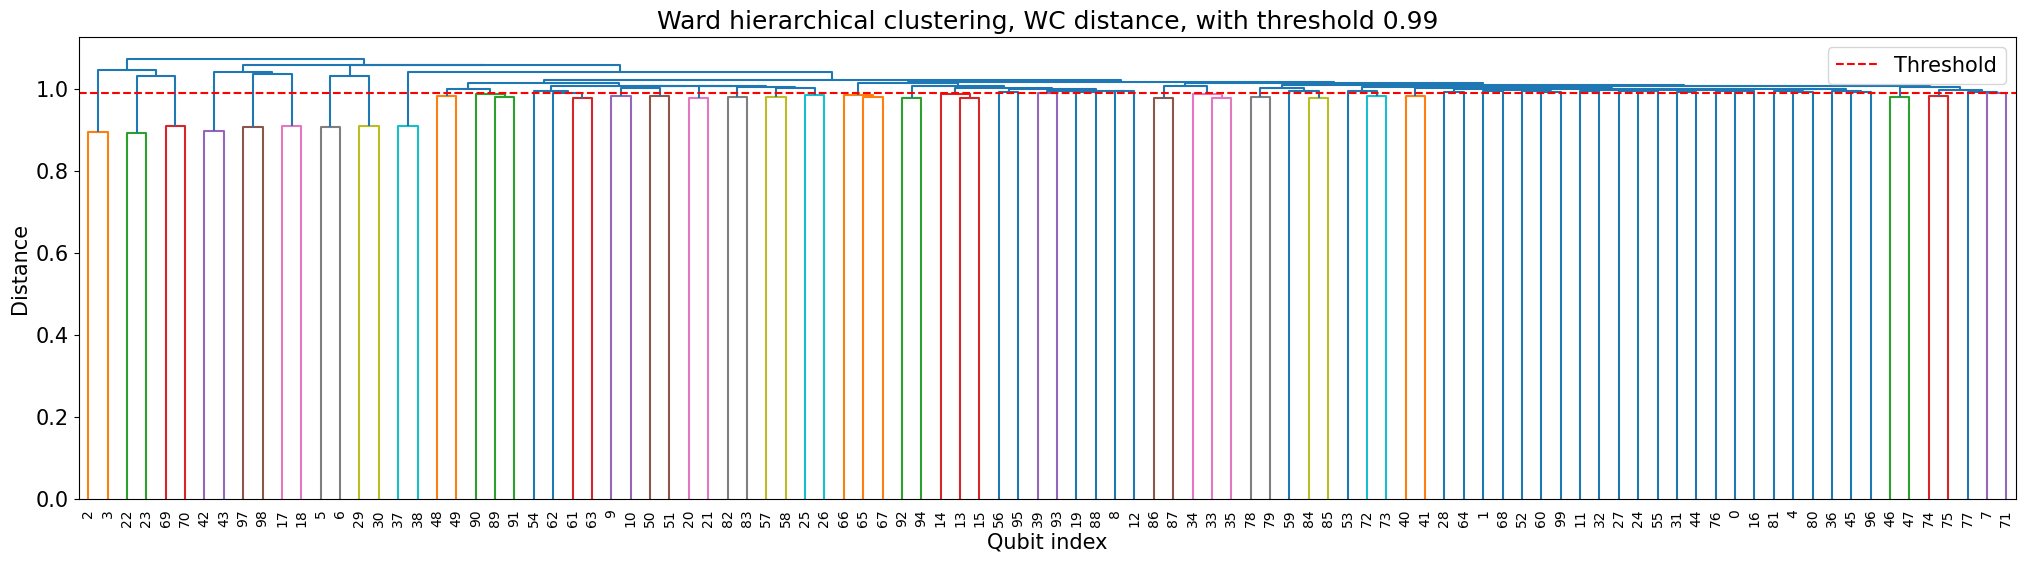

In [13]:
# qrem.perform_clustering(max_cluster_size=3)
# vis.plot_dendrogram(qrem)
new_cutoff = 0.99
qrem.update_cluster_cutoff(new_cutoff)
vis.plot_dendrogram(qrem, save_png=True, plot_shape=(25,6))

In [14]:
qrem.reconstruct_all_one_qubit_POVMs()
qrem.reconstruct_cluster_POVMs()
qrem.reconstruct_cluster_with_perfect_clustering()
n_averages = 1
chunk_size = 4
qrem.set_chunked_true_states(n_averages=n_averages, chunk_size=chunk_size)
qrem.perform_averaged_QST_measurements()



[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:   18.4s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   22.4s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   27.6s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   33.9s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   40.7s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   47.6s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   55.6s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.0min
[Parallel(n_jobs=9)]: Done  94 out of 100 | elapsed:  1.2min remaining:    4.4s
[Parallel(n_jobs=9)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:   14.1s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   28.8s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   40.7s
[Parallel(n_jobs=9)]: Done  3

In [44]:
n_pairs = 15
selected_two_point_corr_labels =  np.array([[0,1],[2,3],[4,5],[6,7],[8,9], [10,11], [12,13], [14,15], [16,17], [18,19], [20,21], [22,23]])
qrem.set_two_point_correlators( two_point_corr_labels = selected_two_point_corr_labels)
recon_mode = [0,2,5]

standard_dict = qrem.perform_two_point_correlator_QST(recon_mode)
perfect_clustering_dict = qrem.perform_two_point_correlator_QST(recon_mode, assume_perfect_clustering=True)

dict_array = [standard_dict, perfect_clustering_dict]

with open(f'{qrem.data_path}/result_QST.npy', 'wb') as f:
    np.save(f, dict_array)

perm_data_path = f'{qrem.data_path}'

Set current two-point correlators to [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]
 [20 21]
 [22 23]].


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   4 out of  12 | elapsed:    6.2s remaining:   12.6s
[Parallel(n_jobs=9)]: Done   7 out of  12 | elapsed:    7.2s remaining:    5.1s
[Parallel(n_jobs=9)]: Done  10 out of  12 | elapsed:    7.6s remaining:    1.4s
[Parallel(n_jobs=9)]: Done  12 out of  12 | elapsed:    8.2s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:   13.7s
[Parallel(n_jobs=9)]: Done   3 out of  12 | elapsed:   13.7s remaining:   41.4s
[Parallel(n_jobs=9)]: Done   5 out of  12 | elapsed:   13.8s remaining:   19.4s
[Parallel(n_jobs=9)]: Done   7 out of  12 | elapsed:   13.9s remaining:    9.9s
[Parallel(n_jobs=9)]: Done   9 out of  12 | elapsed:   13.9s remaining:    4.6s
[Parallel(n_jobs=9)]: Done  12 out of  12 | elapsed:   21.3s finished


POVM shape (4, 4, 4)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM already sorted.
POVM already sorted.
POVM shape (4, 4, 4)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (8, 8, 8)
POVM shape (8, 8, 8)
POVM shape (16, 16, 16)
POVM already sorted.
POVM shape (16, 16, 16)
POVM already sorted.
POVM already sorted.
POVM already sorted.


[[1.099e-03 1.249e-05 8.022e-06]
 [1.359e-02 7.849e-05 7.849e-05]
 [2.296e-02 7.316e-04 7.475e-05]
 [3.635e-02 5.394e-04 8.269e-05]
 [2.530e-03 2.295e-05 7.962e-06]
 [2.903e-04 2.437e-05 6.216e-06]
 [1.457e-03 3.039e-05 3.438e-06]
 [1.965e-03 5.598e-05 3.787e-05]
 [1.323e-02 1.660e-04 1.149e-04]
 [2.008e-02 1.019e-03 2.091e-04]
 [3.237e-03 1.202e-05 1.202e-05]
 [3.312e-02 4.776e-05 4.776e-05]]
[ 5  0  6  7  4 10  8  1  9  2 11  3]


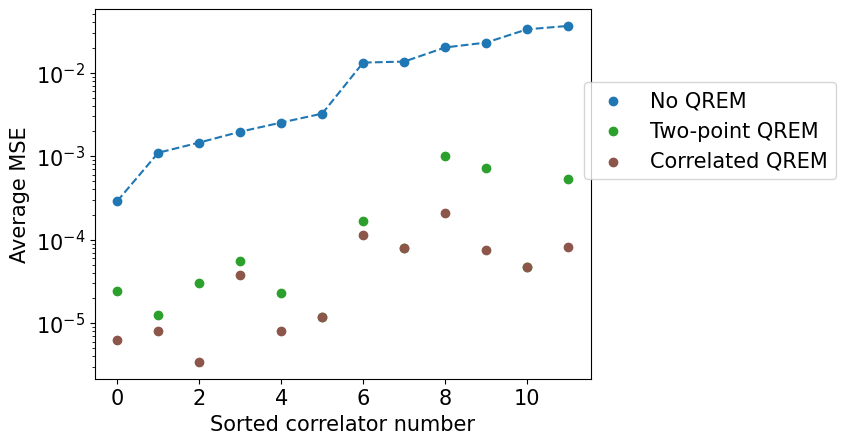

In [68]:
with open(f'{perm_data_path}/result_QST.npy', 'rb') as f:
    dict_array = np.load(f, allow_pickle=True)
    
standard_dict = dict_array[0]
perfect_clustering_dict = dict_array[1]
n_averages = standard_dict['n_average']
two_point_corr_labels   = standard_dict['two_point_corr_labels']
traced_down_rho_true_array = standard_dict['traced_down_rho_true_array']

standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_dict)
perfect_state_array, _ = ot.load_state_array_from_result_dict(perfect_clustering_dict)


n_op = 25
op_string_array = ot.generate_random_pauli_string(n_op,2)



true_exp_value = ot.compute_state_array_exp_values([traced_down_rho_true_array],op_string_array)[0]
stadard_exp_value = ot.compute_state_array_exp_values(standard_state_array,op_string_array)

standard_mean_MSE = ot.compute_op_and_n_averages_mean_MSE(stadard_exp_value, true_exp_value)
perfect_clustering_exp_value = ot.compute_state_array_exp_values(perfect_state_array,op_string_array)
perfect_clustering_MSE = ot.compute_op_and_n_averages_mean_MSE(perfect_clustering_exp_value, true_exp_value)

print(standard_mean_MSE.T)

sorting_arg = np.argsort(standard_mean_MSE.T[:,0])
print(sorting_arg)
sorted_MSE = standard_mean_MSE.T[sorting_arg]
perfect_sorted_MSE = perfect_clustering_MSE.T[sorting_arg]
colors = ['C0', 'C2',  'C5']
fig, ax = plt.subplots(1,1)
ax.plot(sorted_MSE[:,0],linestyle='dashed' )
for i in range(len(sorted_MSE[0])):
    ax.scatter(np.arange(len(sorted_MSE[:,i])), sorted_MSE[:,i],label = label_array[i], color = colors[i])
#ax.scatter(np.arange(len(sorted_MSE[:,0])), perfect_sorted_MSE[:,2],label = 'Perfect clustering', marker='x')
# MSE of shape [n_method , n_correlators]
# for i in range(len(label_array)):
#     ax.bar(i, standard_mean_MSE[i], label=label_array[i])
#     ax.plot(i, perfect_clustering_MSE[i], "kx")
ax.set_yscale('log')
ax.set_ylabel(f'Average MSE')
ax.set_xlabel('Sorted correlator number')
fig.legend(bbox_to_anchor=(1.3,0.75))
corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]





# GHZ states comparison with RShadow

# Runtime/scaling visualization

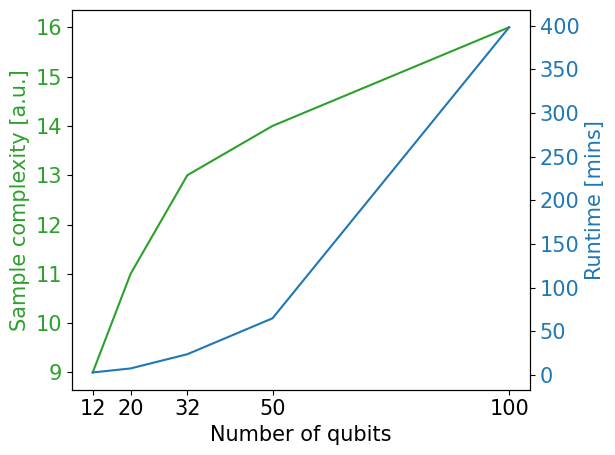

In [ ]:
# Create some mock data
n_qubits = [12, 20,32,50,100]
sample_complexity = np.array([9,11,13,14,16])#np.join(([1,2,3],[])))
comp_runtime = [3,7.6,23.9,65,398]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel(r'Sample complexity [a.u.]',color=color)
ax1.plot(n_qubits, sample_complexity,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set(xticks=n_qubits)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Runtime [mins]', color=color)  # we already handled the x-label with ax1
ax2.plot(n_qubits, comp_runtime, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
